In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network
## Session 04a
### Neural Network with :
- One hidden layer 
- ${Tanh}$ activation function

#### Session 6 topics with one hidden layer:
- Forward Passing
- Loss function
- Cost Function

<img src='../../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [3]:
###----------------
### Some parameters
###----------------

inpDir = '../../../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 20001 # number of epochs
ALPHA = 0.1 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

# Parameters for plotting
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium',
         }

CMAP = plt.cm.coolwarm
plt.rcParams.update(params)
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

### Helper Functions

In [4]:
###-----------------------------------
### Function to plot Decision boundary
###-----------------------------------

def fn_plot_decision_boundary(pred_func: Callable[[], np.float64], 
                              X_tr: np.ndarray, 
                              y_tr: np.ndarray, 
                              X_ts :  np.ndarray, 
                              y_ts:  np.ndarray,):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X_tr : train feature matrix
           y_tr : train labels
           X_ts : test feature matrix
           y_ts : test labels
       Return:
           None
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X_tr[:, 0].min() - .05, X_tr[:, 0].max() + .05
    yMin, yMax = X_tr[:, 1].min() - .05, X_tr[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    ax = fig.add_axes(111)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP) #, alpha = 0.8
    
    # Plotting scatter for train data
    ax.scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr,
               s=30, edgecolor='k', cmap=plt.cm.coolwarm)
    
    
    # Plotting scatter for test data
    ax.scatter(X_ts[:, 0], X_ts[:, 1], 
               c=y_ts,
               s=150, marker = '*',
               edgecolor='k', cmap=plt.cm.inferno )


## Generate Data Set
<p style="font-family: Arial; font-size:1.2em;">
Use Sklearn's dataset generator <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a>.
</p>

#### You may want to experiment with make_circles dataset 

In [5]:
X, y = datasets.make_moons(n_samples=NUM_SAMPLES, 
                           shuffle=True, 
                           noise=NOISE, 
                           random_state=RANDOM_STATE)

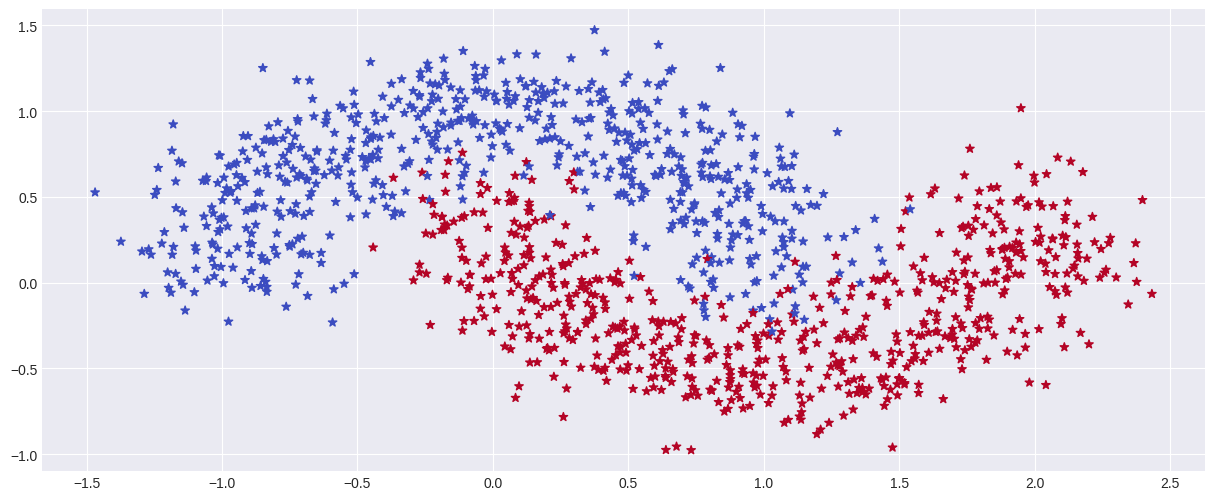

In [6]:
# Lets plot the data
plt.scatter(X[:,0], X[:,1], s=40, c=y, marker='*', cmap=CMAP);

In [7]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1024, 2) (1024,) (256, 2) (256,)


In [8]:
# if you really want to save on space, convert to float32

X_train = X_train.astype(np.float32)

X_test = X_test.astype(np.float32)

y_train = y_train.astype(np.float32)

y_test = y_test.astype(np.float32)

## Single neuron
<img src="../../../images/dnn_nb_s03_fig1.png" width='400' align = 'left'>

## Single Perceptron
<img src="../../../images/dnn_nb_s03_fig2.png" width='400' align = 'left'>

### For single row of perceptrons:
<img src="../../../images/dnn_nb_s04_fig3.png" width='800' align = 'left' alt = 'Two in a row'>

### For single perceptron:
   
$
\begin{aligned}
a &=  \sigma(z)\\
a &=  \sigma(x_1.w_1 + x_2.w_2 + b)\\ 
a &= \sigma\ ( [ x_1, x_2 ] \circ
\begin{bmatrix} w_1 \\ w_2 \end{bmatrix}  + b )\\
\end{aligned}
$

#### For multiple Rows of X:

$
\begin{aligned}
a &= \sigma\ (\begin{bmatrix} x_1^{(1)} & x_2^{(1)}\\ 
x_1^{(2)} & x_2^{(2)}\\
x_1^{(...)} & x_2^{(...)}\\
x_1^{(m)} & x_2^{(m)} \end{bmatrix} \circ
\begin{bmatrix} w_1 \\ w_2 \end{bmatrix}  + b )\\
\end{aligned}
$

In matrix form it can be represented as:

$
\begin{aligned}
a &= \sigma\ ( X_{shape = (m,2)} \circ W_{shape = (2,1)}^{[1]} + b_{shape = (1,1)})
\end{aligned}
$

**Note:** Please note that Python is going to broadcast b in all $'m'$ rows. Avoid any confusion, always maintain dimensions of $b$.

### For single row of perceptrons:

$
\begin{aligned}
a^{[1]} &= g ( X_{shape = (m,2)} \circ W_{shape = (2,1)}^{[1]} + b_{shape = (1,1)}^{[1]})\\
a^{[2]} &= \sigma ( a^{[1]}_{shape = (m,1)} \circ W_{shape = (1,1)}^{[2]} + b_{shape = (1,1)}^{[2]})\\
Cost &= \text{Loss function} = y \circ log_e (a^{[2]})
\end{aligned}
$

We will be using $\tanh$ function for layer 1 (hidden layer) as it fits in majority of cases and its derivative can simply be represented as 1 -$\tanh^2(z_1)$. Since our output is binary, it makes sense to use $\text{Sigmoid}$ in the last layer.

## Neural Network

Let's start with simple network. Our data has **two** features. Hence size of input layer will also be two. The output is binary, we can code it as single column as well as double column output. The hidden layer could be of **any size**. One need to execute a handful of iterations to arrive at right size of hidden layer. For purpose of today's discussions, size of hidden layer is taken as shown below.

<img src='../../../images/dnn_nb_s04_fig2.png' width = '500'/>

## What is this hidden layer?

<img src='../../../images/dnn_nb_s04_fig5.png' width = '500'/>

## Forward Propagation

### For single Neuron:
$\text{activations (a)} = \text{activation function} ( X \circ W_1 + b)$

Hence for hidden layer, we can write as follows:

$
\begin{aligned}
z_1^{[1]} & = X . W_1^{[1]} + b_1^{[1]}\\
a_1^{[1]} & = \tanh(z_1^{[1]}) \\
\\
z_2^{[1]} & = X . W_2^{[1]} + b_2^{[1]} \\
a_2^{[1]} & = \tanh(z_2^{[1]}) \\
\\
z_3^{[1]} & = X . W_3^{[1]} + b_3^{[1]} \\
a_3^{[1]} & = \tanh(z_3^{[1]}) \\
\\
z_4^{[1]} & = X . W_4^{[1]} + b_4^{[1]} \\
a_4^{[1]} & = \tanh(z_4^{[1]}) \\
\\
\text{Or}\\
a^{[1]} &= \tanh(X \circ \begin{bmatrix} W_1^{[1]}, &W_2^{[1]}, &W_3^{[1]}, &W_4^{[1]}\end{bmatrix} + \begin{bmatrix}b_1^{[1]}, &b_2^{[1]}, &b_3^{[1]}, &b_4^{[1]}\end{bmatrix} )\\
\end{aligned}
$



<hr>

If we convert above to matrix version, we can say.

$
\begin{aligned}
\text{Replace:}\\
W^{[1]} & = \begin{bmatrix} W_1^{[1]}, &W_2^{[1]}, &W_3^{[1]}, &W_4^{[1]}\end{bmatrix}\\
b^{[1]} & = \begin{bmatrix}b_1^{[1]}, &b_2^{[1]}, &b_3^{[1]}, &b_4^{[1]}\end{bmatrix}\\
\text{Hence:}
\\z_{shape = (m,4)}^{[1]} & = X_{shape = (m,2)} \circ W_{shape=(2,4)}^{[1]} + b_{shape = (1,4)}^{[1]} \\
\\
a_{shape = (m,4)}^{[1]} & = \tanh(z^{[1]}) \\
\end{aligned}
$

Similarly for second layer.

$
\begin{aligned}
z_{shape = (m, 1)}^{[2]} & = a_{shape = (m,4)}^{[1]} \circ W_{shape=(4,1)}^{[2]} + b_{shape = (1,1)}^{[2]} \\
\\
a_{shape = (m, 1)}^{[2]} & = \hat{y} = \mathrm{sigmoid}(z^{[2]})\\
\end{aligned}
$

Where:

Sigmoid $\sigma$: 

$\sigma(z) = \dfrac{1}{1 + e^{-z}}$

## Activation Functions

### Sigmoid Function

In [9]:
# sigmoid function is applied to each Value independently
def fn_sigmoid(z : np.ndarray)-> np.ndarray:
    '''
    Args:
        z : a matrix of z values of shape (m, n_output)
    returns:
        sigmoid values of z
    
    '''
    
    return 1 / ( 1 + np.exp ( -z ) )
    

In [10]:
sm = fn_sigmoid(np.asarray([[-1, 0., 1.], [-np.inf, 0., np.inf]]))
print (sm)

[[0.26894142 0.5        0.73105858]
 [0.         0.5        1.        ]]


### Tanh Activation Function

In [11]:
def fn_tanh(z: np.ndarray) -> np.ndarray:
    
    '''
        Args:
           z : array, Aggregated values 
       Return:
           Activations for each z
    '''

    return np.tanh(z)

def fn_tanh_prime(a: np.ndarray) -> np.ndarray:
    '''
        Args:
           a : array, Aggregated values 
       Return:
           Derivative, for each a
    '''

    return 1.0 - np.tanh(a)**2

In [12]:
fn_tanh(np.asarray([[-1, 0., 1.], [-np.inf, 0., np.inf]]))

array([[-0.76159416,  0.        ,  0.76159416],
       [-1.        ,  0.        ,  1.        ]])

### Is our Activation Function working?

In [13]:
np.tanh(0.5)

np.float64(0.46211715726000974)

In [14]:
(1 - np.power(np.tanh(0.5), 2))

np.float64(0.7864477329659274)

In [15]:
fn_tanh_prime(0.5)

np.float64(0.7864477329659274)

## Predict Function

For predictions, we will simply be using the forward propagation. No need to iterate or calculate the back propagation for supervised learning.


In [16]:
# Helper function to predict an output (0 or 1)

def predict(model : dict, X: np.ndarray) -> np.ndarray:
    '''
     Args:
         model
         X: input features
    Returns:
        Predictions against the instances
         
    '''
    W1, b1, W2, b2 = model['W1'],model['b1'],model['W2'],model['b2']
    
    #### Forward Propagation   
    # Layer 1
    z1 = X.dot(W1) + b1 # Aggregation
    a1 = fn_tanh (z1) # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2
    a2 = fn_sigmoid(z2)
    
    return a2>=0.5 # Is it greater than 0.5?

## Loss Function

We need to minimize the error by adjusting (W's, b's). We call the function that measures our error the <b>loss function</b>. A common choice with the sigmoid output is the cross-entropy loss. The loss for predictions $\hat{y}$ with respect to the true labels $y$ is given by:

$
\begin{aligned}
L(\hat{y_i}, y_i) =  -\begin{bmatrix}y_i.log(\hat{y_i}) + (1 - y_i) . log(1-\hat{y_i})\end{bmatrix}\\
\end{aligned}
$

For all samples:

$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum_{i=1}^{m}\begin{bmatrix}y_i.log(\hat{y}_i) + (1-y_i) . log(1-\hat{y}_i)\end{bmatrix}\\
\end{aligned}
$

### In case of Binary Classification:

$
\begin{aligned}
L(\hat{y_i}, y_i) =  -y_i.log(\hat{y_i})
\end{aligned}
$

For all samples:

$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum_{i=1}^{m}y_i.log(\hat{y}_i)
\end{aligned}
$


We can use gradient descent to find its minimum. For purpose of this Session, let's use it in its simplest form - <b>batch gradient descent with fixed learning rate</b>.

In [17]:
# function to evaluate the total loss on the dataset

def calculate_loss(model : dict, X: np.ndarray, y: np.ndarray) -> np.float64:
    '''
    Args:
        model: dictionary object containing weights and biases
        X: Feature Matrix
        y: Labels array
    Returns:
        Average loss
    '''
    W1, b1, W2, b2 = model['W1'],model['b1'],model['W2'],model['b2']
    
    m = X.shape[0] # num of samples
    
    #### Forward Propagation   
    # Layer 1
    z1 = X.dot(W1) + b1 # Aggregation
    a1 = fn_tanh (z1) # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2
    a2 = fn_sigmoid(z2)
    
    data_loss = -(y* np.log(a2)).sum()

    return 1./m * data_loss

## For a single row of data x

<img src='../../../images/dnn_nb_s04_fig4.png' style='width: 800px;'/>

As an input, gradient descent needs the gradients (vector of derivatives) of the loss function with respect to our parameters: 

$\frac{\partial{L}}{\partial{W_1}}(= \partial{W^{[1]}})$, $\frac{\partial{L}}{\partial{b_1}}(= \partial{b^{[1]}})$, $\frac{\partial{L}}{\partial{W_2}}(= \partial{W^{[2]}})$, $\frac{\partial{L}}{\partial{b_2}}(= \partial{b^{[2]}})$. 

To calculate these gradients we use the <b>back-propagation algorithm</b>.

**Note:** Loss is a function of $a^{[2]}$ which is a function of $z^{[2]}$ and so on. It can be further represented as follows:<br>
$
\begin{aligned}
Loss &= f_1(a^{[2]})\\
a^{[2]} &= f_2(z^{[2]})\\
z^{[2]} &= f_3(a^{[1]})\\
a^{[1]} &= f_4(z^{[1]})\\
\text{Therefore:}\\
\frac{\partial{Loss}}{\partial{z^{[1]}}} &= \frac{\partial{Loss}}{\partial{z^{[2]}}} \circ
\frac{\partial{z^{[2]}}}{\partial{a^{[1]}}} \circ \frac{\partial{a^{[1]}}}{\partial{z^{[1]}}} 
\end{aligned}
$

## Back-propagation for all Rows
For all rows, equations will remain same and the values will be divided by <b><i>'m'</i></b>; number of samples.

$
\begin{aligned}
\partial{z^{[2]}}  & = a^{[2]} - y  \\
\partial{W^{[2]}}  & = \frac{1}{m} a^{[1]T}\circ \partial{z^{[2]}} \\
\partial{b^{[2]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[2]}}, axis = 0, keepdims = True) \\
\\
\partial{z^{[1]}}  & = \partial{z^{[2]}}\circ  W^{[2]T} * ( 1-a^{[1]}**2)\\
\partial{W^{[1]}}  & = \frac{1}{m} X^{T}\circ \partial{z^{[1]}} \\
\partial{b^{[1]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[1]}}, axis = 0, keepdims = True) \\
\\
\end{aligned}
$

## Notes:


We have transposed a few matrices in above calculations such as $a^{[1]}$, $W^{[2]}$ and X. A review of shapes of matrices will reveal that this adjustment is needed to have consistent sizes. e.g.

- Shape of $a^{[1]}$ and $\partial{z}^{[2]}$ are ( m, 4) and ( m, 1 ) respectively. Expected shape of $\partial{W^{[2]}}$ is ( 4, 1 ) which is same as that of $W^{[2]}$.
- In equation $\partial{z^{[1]}}  = \partial{z^{[2]}}\circ  W^{[2]T} * ( 1-a^{[1]}**2)$ shape of $z^{[2]}$,  $W^{[2]}$ and $a^{[1]}$ are (m,1), (4,1) and (m,4). For element wise multiplication, expected shape of dot product of is $z^{[2]}$ and $W^{[2]}$ is ( m, 4 ).
- Lastly, shape of $\partial{W^{[1]}}$ is (2,4) and that of X and $\partial{z^{[1]}}$ are ( m, 2 ) and ( m, 4 ).

## Model

In [18]:
# prepare the Model

def build_model(nn_hdim : np.int64, 
                X : np.ndarray, 
                y : np.ndarray, 
                epochs: np.int64 = EPOCHS, 
                alpha: np.float64 = ALPHA) -> dict:
    
    '''
    Args:
        nn_hdim : Number of nodes in the hidden layer
        X : np.ndarray; Training features to train
        y : np.ndarray; Training targets (labels)
        epochs : Number of passes through the training data for gradient descent
        alpha : learning rate
        
    Returns:
        Model: Dictionary object containing weights and biases
    '''
    
    # Initialize the parameters to random values. We need to learn these Weights
    
    '''
    ##### 
            Change from np.random.rand to np.random.randn gives different shape of the loss curve
    #####
    '''

    m, nn_input_dim = X_train.shape # training set size (rows and cols)
    nn_output_dim = y.shape[1]
    
    W1 = np.random.rand(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    W2 = np.random.rand(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    
    b1 = np.zeros ((1, nn_hdim))
    b2 = np.zeros ((1, nn_output_dim))
    
    curr_loss = 0
    
    loss = []
    epoch = []
    
    for i in range (0, epochs):
        
        #### Forward Propagation
        
        # Layer 1
        z1 = X.dot(W1) + b1 # Aggregation
        a1 = fn_tanh (z1) # Activation
        
        # Layer 2
        z2 = a1.dot(W2) + b2
        a2 = fn_sigmoid(z2)
        
        ### Back Propagation

        # Layer 2
        dz2 = a2 - y
        
        dW2 = (a1.T).dot(dz2)
        assert (W2.shape == dW2.shape), 'Shape of W2 {} and shape of dW2 {}'.format(W2.shape, dW2.shape)
        
        db2 = np.sum(dz2, axis = 0, keepdims=True)
        assert (b2.shape == db2.shape), 'Shape of b2 {} and shape of db2 {}'.format(b2.shape, db2.shape)
        
        da1 = dz2.dot(W2.T)
        assert (a1.shape == da1.shape), 'Shape of a1 {} and shape of da1 {}'.format(a1.shape, da1.shape)

        # Layer 1
        dz1 = da1 * fn_tanh_prime(z1)
        assert (z1.shape == dz1.shape), 'Shape of z1 {} and shape of dz1 {}'.format(z1.shape, dz1.shape)

        dW1 = (X.T).dot(dz1)
        assert (W1.shape == dW1.shape), 'Shape of W1 {} and shape of dW1 {}'.format(W1.shape, dW1.shape)
        db1 = np.sum(dz1, axis = 0, keepdims=True)
        assert (b1.shape == db1.shape), 'Shape of b1 {} and shape of db1 {}'.format(b1.shape, db1.shape)

        ########################
        ### Gradient Updates ###
        ########################
        # gradients are being updated for every epoch
        W1 += -alpha *dW1 / m
        W2 += -alpha *dW2 / m
        b1 += -alpha *db1 / m
        b2 += -alpha *db2 / m
        
        # Store model in a dict object
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # for every nth epoch calculate loss for future plotting
        if i%100 ==  0:
            curr_loss = calculate_loss (model, X, y)
            loss.append(curr_loss)
            epoch.append(i)
            
        # print loss every nth epoch    
        if i%1000 == 0:
            print ('loss after {} epochs : {}'.format(i,curr_loss))
    
    # update loss_hist
    loss_hist['epoch'] =epoch
    loss_hist['loss'] = loss
    
    
    return model

In [19]:
# lists to facilitate plotting 
loss_hist = {}

**Note:** - The vector y_train is being converted to 2-dimensional array

In [20]:
y_train = y_train.reshape(-1,1)
y_train.shape

(1024, 1)

In [21]:
# Build a model with a 4-dimensional hidden layer
model = build_model(4, X_train, y_train, 
                    epochs = EPOCHS, 
                    alpha = ALPHA)

loss after 0 epochs : 0.2975464894196189
loss after 1000 epochs : 0.148327729184851
loss after 2000 epochs : 0.10529788144380808
loss after 3000 epochs : 0.07204699759314803
loss after 4000 epochs : 0.051189206593804715
loss after 5000 epochs : 0.0434426250349737
loss after 6000 epochs : 0.04070659354191448
loss after 7000 epochs : 0.03959934999765885
loss after 8000 epochs : 0.03909206747090136
loss after 9000 epochs : 0.03883557764780686
loss after 10000 epochs : 0.0386934812357744
loss after 11000 epochs : 0.03860581493610833
loss after 12000 epochs : 0.038543401564614
loss after 13000 epochs : 0.03849049846456406
loss after 14000 epochs : 0.038437638178642666
loss after 15000 epochs : 0.038378940802563974
loss after 16000 epochs : 0.038311779002766166
loss after 17000 epochs : 0.03823707398518342
loss after 18000 epochs : 0.03815841707325693
loss after 19000 epochs : 0.038079885013854384
loss after 20000 epochs : 0.03800428299830342


In [22]:
model

{'W1': array([[ 2.79041315,  2.44973647,  3.47216862,  2.91766123],
        [-1.55566552, -0.64631346,  2.15366289, -1.44832853]]),
 'b1': array([[-3.48402764,  1.50405901, -2.11977869,  1.25236474]]),
 'W2': array([[ 6.79080732],
        [ 3.17545367],
        [-6.69467415],
        [ 4.44762638]]),
 'b2': array([[-0.61155664]])}

Would contest that we should have used higher epochs as loss is still coming down. 

### Question
- How many epochs are sufficient?

## Make predictions

In [23]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :', accuracy_score(y_train, y_pred))

Accuracy score on Train Data : 0.96875


In [24]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       522
         1.0       0.97      0.97      0.97       502

    accuracy                           0.97      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.97      0.97      0.97      1024



In [25]:
y_pred = predict(model, X_test)

print('Accuracy score on Test Data :', accuracy_score(y_test, y_pred))

Accuracy score on Test Data : 0.95703125


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       118
         1.0       0.96      0.96      0.96       138

    accuracy                           0.96       256
   macro avg       0.96      0.96      0.96       256
weighted avg       0.96      0.96      0.96       256



## Plot loss and decision boundary

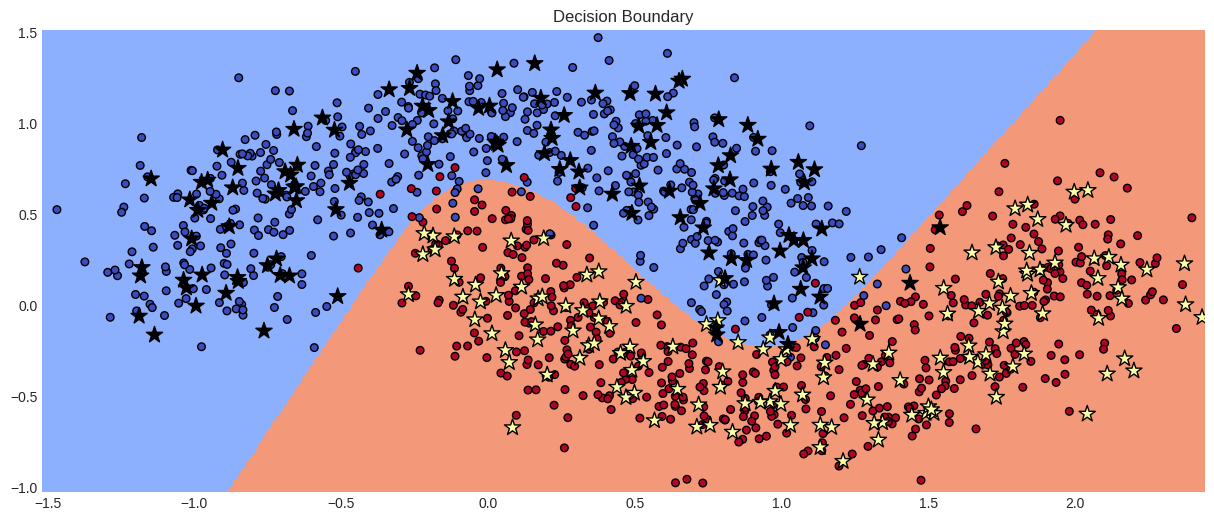

In [27]:
loss_df = pd.DataFrame(loss_hist)

fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train, X_test, y_test) # plot decision boundary for this plot

plt.title("Decision Boundary");

## How weights mature!
- See on the video in the output directory.

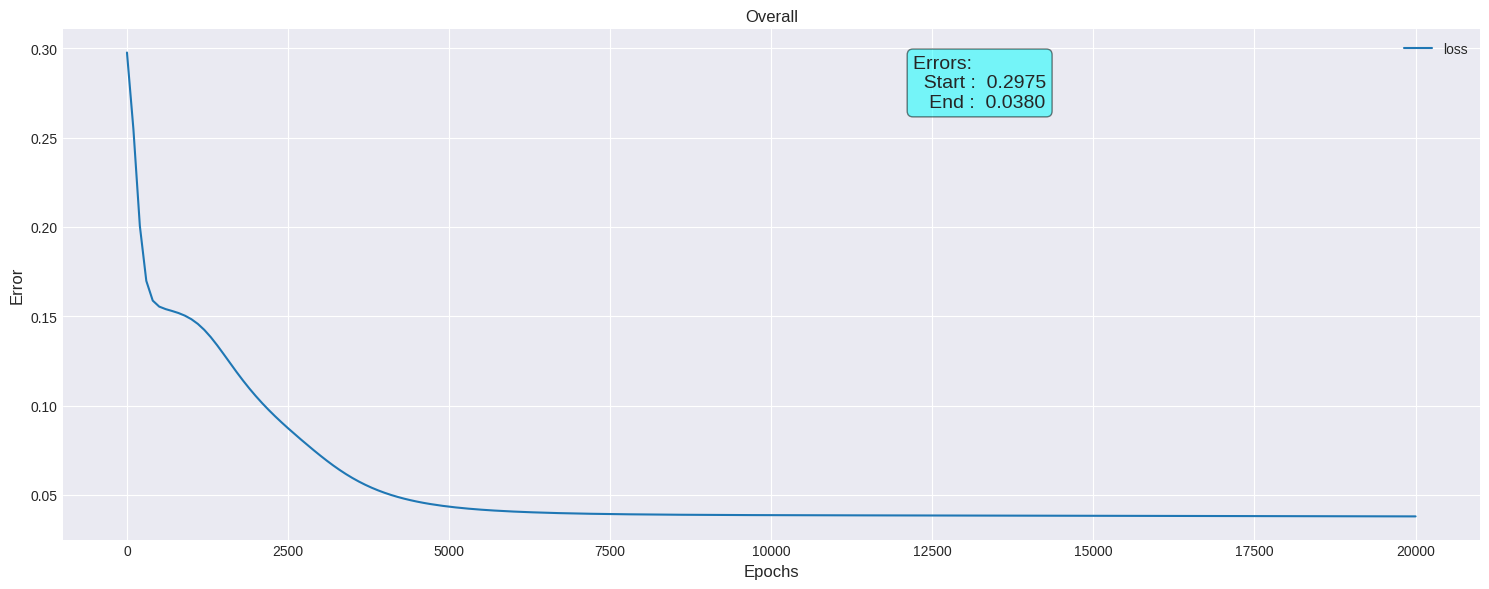

In [31]:
fig, ax = plt.subplots()

loss_df.plot(x = 'epoch', y = 'loss', ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0]['loss'],
                                                                loss_df.iloc[-1]['loss']) #text to plot

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='aqua', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')
plt.tight_layout()

In [29]:
cm  = confusion_matrix(y_test, y_pred)
cm

array([[113,   5],
       [  6, 132]])

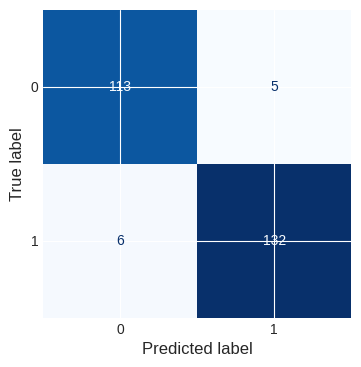

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False)

plt.show();